### Inferring the spins of merging black holes in the presence of data-quality issues

Notebook to reproduce Figure 2


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.cm as cm
import matplotlib
import matplotlib.ticker as ticker
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams.update({'font.size': 17})
import matplotlib.lines as mlines
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import copy
import seaborn as sns
import matplotlib.gridspec as gridspec

### Load results

In [2]:
#injected 1D glitch (single wavelet), recovered model 1D
df_D1_SNR10 = "/home/sophie.bini/BW/BW_CPP/glitch_residual/O3_L1_glitch_fixedSNR_10_20_run1/output_SNR.txt"
df_D1_SNR5 = "/home/sophie.bini/BW/BW_CPP/glitch_residual/O3_L1_glitch_fixedSNR_5_50_D1_run1/output_SNR.txt"

#injected 1D glitch, recovered with trandimensional model with up to 5 wavelets (Dmax=5)
df_D5_SNR10 = "/home/sophie.bini/BW/BW_CPP/glitch_residual/O3_L1_glitch_fixedSNR_10_20_D5_run1/output_SNR.txt"
df_D5_SNR5 = "/home/sophie.bini/BW/BW_CPP/glitch_residual/O3_L1_glitch_fixedSNR_5_50_run1/output_SNR.txt"

#injected multiple wavelets D=10, recovered with Dmax=5 and Dmax=10
df_var5 = "/home/sophie.bini/BW/BW_CPP/glitch_residual/O3_L1_glitch_fixedSNR_multipleW_1s_recoveryDmax5_run3/output_SNR.txt"
df_var10 = "/home/sophie.bini/BW/BW_CPP/glitch_residual/O3_L1_glitch_fixedSNR_multipleW_1s_recoveryDmax10_run4/output_SNR.txt"

#injected wavelet D=10, recovered Dmax=10, and Dfixed=10
df_N10_fix10 = "/home/sophie.bini/BW/BW_CPP/glitch_residual/O3_L1_glitch_fixedSNR_inj_fixD10_1s_rec_fixD10/output_SNR.txt"
df_N10_dmax10 = "/home/sophie.bini/BW/BW_CPP/glitch_residual/O3_L1_glitch_fixedSNR_inj_fixD10_1s_rec_Dmax10/output_SNR.txt"

#injected wavelet D=3, recovered Dmax=3, Dfix =3
df_N3_fixD3= "/home/sophie.bini/BW/BW_CPP/glitch_residual/O3_L1_glitch_fixedSNR_inj_fixD3_1s_rec_fixD3/output_SNR.txt"
df_N3_dmax5= "/home/sophie.bini/BW/BW_CPP/glitch_residual/O3_L1_glitch_fixedSNR_inj_fixD3_1s_rec_Dmax5/output_SNR.txt"


In [3]:
#read all dataset
df_D1_SNR5 = pd.read_csv(df_D1_SNR5,sep='\s+')
df_D1_SNR10 = pd.read_csv(df_D1_SNR10,sep='\s+')

df_D5_SNR5 = pd.read_csv(df_D5_SNR5,sep='\s+')
df_D5_SNR10 = pd.read_csv(df_D5_SNR10,sep='\s+')

df_var5 = pd.read_csv(df_var5,sep='\s+')
df_var10 = pd.read_csv(df_var10,sep='\s+')

df_N10_fix10 = pd.read_csv(df_N10_fix10,sep='\s+')
df_N10_dmax10 = pd.read_csv(df_N10_dmax10,sep='\s+')

df_N3_fixD3 = pd.read_csv(df_N3_fixD3,sep='\s+')
df_N3_dmax5 = pd.read_csv(df_N3_dmax5,sep='\s+')

df_N3_dmax5.head() #check

,injected_SNR,residual_SNR_maxL,residual_SNR_rd,residual_SNR_med
0,5.0,7.601085,5.000000,5.000000
1,10.0,5.877843,5.498187,4.778815
2,20.0,5.631158,4.161660,3.169141
3,30.0,6.668488,5.240876,3.257350
4,40.0,8.521630,4.338919,3.407878


In [4]:
#only for the first dataset: merge dataframe D5 (first set of injections SNR 10, 20 splitted from 5, 30, 40,50), the others dataset contains {5,10,20,30,40,50] SNRs
print(df_D5_SNR5.shape, df_D5_SNR10.shape)
df_D5_SNR10 = df_D5_SNR10[1:].reset_index()
print(df_D5_SNR10.shape)
results_D5 = pd.concat([df_D5_SNR5, df_D5_SNR10], axis=0, ignore_index=True)
print(df_D1_SNR5.shape, df_D1_SNR10.shape) #check
results_D1 = pd.concat([df_D1_SNR5, df_D1_SNR10], axis=0, ignore_index=True)

(99, 4) (100, 4)
(99, 5)
(100, 4) (100, 4)


In [5]:
#open time-series for figure 2 second panel
df = pd.read_csv('../timeseries_for_plot.txt',  sep="\t")
df.head()

,injection,median,maxL,fairdraw
0,0.002536,0.001131,0.002689,0.000558
1,0.005113,0.003326,0.006055,0.006518
2,0.003370,0.002740,0.004452,0.007131
3,-0.001175,-0.000116,-0.000805,0.001896
4,-0.004631,-0.003006,-0.005404,-0.004894


### Final plot 

In [6]:
#plot glitch residual vs injected glitch SNR for three cases (panel 1) 

def plot_residuals_3D(ax, df, df1, df2, name, name_empty, name_third):
    """
    Draws residuals with 3 reconstruction styles on a given Axes.
    Compatible with multi-panel layouts.
    """
    snr_values = [5, 10, 20, 30, 40]
    cmap = matplotlib.colormaps.get_cmap('inferno')
    colors = [cmap(i) for i in np.linspace(0, 1, 6)]

    # Loop over SNRs
    for i, snr in enumerate(snr_values, start=1):
        # --- df (first dataset) ---
        df_snr = df[df["injected_SNR"] == snr]
        ax.errorbar(i-0.4, np.mean(df_snr["residual_SNR_med"]),
                    yerr=np.std(df_snr["residual_SNR_med"]),
                    color=colors[2], fmt='o', markersize=7, capsize=4,
                    label='Median' if i == 1 else "")
        ax.errorbar(i-0.1, np.mean(df_snr["residual_SNR_maxL"]),
                    yerr=np.std(df_snr["residual_SNR_maxL"]),
                    color=colors[2], fmt='s', markersize=7, capsize=4, markerfacecolor='white',
                    label='Maximum Likelihood' if i == 1 else "")
        ax.errorbar(i+0.2, np.mean(df_snr["residual_SNR_rd"]),
                    yerr=np.std(df_snr["residual_SNR_rd"]),
                    color=colors[2], fmt='d', markersize=7, capsize=4,
                    label='Random Draw' if i == 1 else "")

        # --- df1 (second dataset) ---
        df1_snr = df1[df1["injected_SNR"] == snr]
        ax.errorbar(i-0.3, np.mean(df1_snr["residual_SNR_med"]),
                    yerr=np.std(df1_snr["residual_SNR_med"]),
                    color=colors[3], fmt='o', markersize=7, capsize=4)
        ax.errorbar(i, np.mean(df1_snr["residual_SNR_maxL"]),
                    yerr=np.std(df1_snr["residual_SNR_maxL"]),
                    color=colors[3], fmt='s', markersize=7, capsize=4, markerfacecolor='white')
        ax.errorbar(i+0.3, np.mean(df1_snr["residual_SNR_rd"]),
                    yerr=np.std(df1_snr["residual_SNR_rd"]),
                    color=colors[3], fmt='d', markersize=7, capsize=4)

        # --- df2 (third dataset) ---
        df2_snr = df2[df2["injected_SNR"] == snr]
        ax.errorbar(i-0.2, np.mean(df2_snr["residual_SNR_med"]),
                    yerr=np.std(df2_snr["residual_SNR_med"]),
                    color=colors[4], fmt='o', markersize=7, capsize=4)
        ax.errorbar(i+0.1, np.mean(df2_snr["residual_SNR_maxL"]),
                    yerr=np.std(df2_snr["residual_SNR_maxL"]),
                    color=colors[4], fmt='s', markersize=7, capsize=4, markerfacecolor='white')
        ax.errorbar(i+0.4, np.mean(df2_snr["residual_SNR_rd"]),
                    yerr=np.std(df2_snr["residual_SNR_rd"]),
                    color=colors[4], fmt='d', markersize=7, capsize=4)

    # Axes formatting
    for i in range(len(snr_values) - 1):
        ax.axvline(i+1 + 0.5, color='grey', linestyle='dashed')

    ax.set_xlabel("Injected SNR")
    ax.set_ylabel("Residual SNR")
    ax.set_ylim(1, 16)
    ax.set_xticks(range(1, len(snr_values) + 1))
    ax.set_xticklabels([str(snr) for snr in snr_values])
    for j in range(0, 10):
        ax.axhline(j*2, color='grey', linestyle='dashed', alpha=0.1)

    # Reference lines
    ax.axhline(np.sqrt(5), color=colors[2], linestyle='--', alpha=0.5, lw=3)
    ax.axhline(np.sqrt(15), color=colors[3], linestyle='--', alpha=0.5, lw=3)
    ax.axhline(np.sqrt(50), color=colors[4], linestyle='--', alpha=0.5, lw=3)

    # Custom legend handles
    median_legend = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=7, label='Median')
    maxL_legend   = mlines.Line2D([], [], color='black', marker='s', linestyle='None', markersize=7,  markerfacecolor='white', label='Maximum-likelihood')
    fairdraw_legend = mlines.Line2D([], [], color='black', marker='d', linestyle='None', markersize=7, label='Random Draw')

    filled_patch   = mlines.Line2D([], [], color=colors[2], marker='o', linestyle='None', markersize=7, label=name)
    empty_patch    = mlines.Line2D([], [], color=colors[3], marker='o', linestyle='None', markersize=7, label=name_empty)
    third_patch    = mlines.Line2D([], [], color=colors[4], marker='o', linestyle='None', markersize=7, label=name_third)

    ax.legend([median_legend, maxL_legend, fairdraw_legend,
               filled_patch, empty_patch, third_patch],
              ['Median', 'Maximum-likelihood', 'Random Draw',
               name, name_empty, name_third],
              loc='upper center', ncols=2, fontsize=12)

    return ax


In [7]:
#plot glitch residual vs injected glitch SNR for two cases(panel 3,4) 

def plot_residuals_2D(ax, df, df1, name, name_empty):
    
    snr_values = [5, 10, 20, 30, 40, 50]

    cmap = matplotlib.colormaps.get_cmap('inferno')
    colors = [cmap(i) for i in np.linspace(0, 1, 6)]

    for i, snr in enumerate(snr_values, start=1):
        df_snr = df[df["injected_SNR"] == snr]
        ax.errorbar(i-0.4, np.mean(df_snr["residual_SNR_med"]), yerr=np.std(df_snr["residual_SNR_med"]),
                    color=colors[4], fmt='o', markersize=7, capsize=4,
                    label='Median' if i == 1 else "")
        ax.errorbar(i-0.1, np.mean(df_snr["residual_SNR_maxL"]), yerr=np.std(df_snr["residual_SNR_maxL"]),
                    color=colors[4], fmt='s', markersize=7, capsize=4, markerfacecolor='white',
                    label='Maximum Likelihood' if i == 1 else "")
        ax.errorbar(i+0.2, np.mean(df_snr["residual_SNR_rd"]), yerr=np.std(df_snr["residual_SNR_rd"]),
                    color=colors[4], fmt='d', markersize=7, capsize=4,
                    label='Fairdraw' if i == 1 else "")
       
        df1_snr = df1[df1["injected_SNR"] == snr]
        ax.errorbar(i-0.3, np.mean(df1_snr["residual_SNR_med"]), yerr=np.std(df1_snr["residual_SNR_med"]),
                    color=colors[2], fmt='o', markersize=7, capsize=4)
        ax.errorbar(i, np.mean(df1_snr["residual_SNR_maxL"]), yerr=np.std(df1_snr["residual_SNR_maxL"]),
                    color=colors[2], fmt='s', markersize=7, capsize=4, markerfacecolor='white')
        ax.errorbar(i+0.3, np.mean(df1_snr["residual_SNR_rd"]), yerr=np.std(df1_snr["residual_SNR_rd"]),
                    color=colors[2], fmt='d', markersize=7, capsize=4)

    # Custom vertical separators
    for i in range(len(snr_values) - 1):
        ax.axvline(i+1 + 0.5, color='grey', linestyle='dashed')

    ax.set_xlabel("Injected SNR")
    ax.set_ylabel("Residual SNR")
    ax.set_ylim(1, 16)
    ax.set_xticks(range(1, len(snr_values) + 1))
    ax.set_xticklabels([str(snr) for snr in snr_values])
    for j in range(0, 10):
        ax.axhline(j*2, color='grey', linestyle='dashed', alpha=0.1)

    # Custom legend markers
    median_legend = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=7, label='Median')
    maxL_legend = mlines.Line2D([], [], color='black', marker='s', linestyle='None', markersize=7,markerfacecolor='white', label='Maximum-likelihood')
    fairdraw_legend = mlines.Line2D([], [], color='black', marker='d', linestyle='None', markersize=7, label='Random Draw')

    filled_patch = mlines.Line2D([], [], color=colors[4], marker='o', linestyle='None', markersize=7, label=name)
    empty_patch = mlines.Line2D([], [], color=colors[2], marker='o', linestyle='None', markersize=7, label=name_empty)

    handles = [median_legend, maxL_legend, fairdraw_legend, filled_patch, empty_patch]
    labels = ['Median', 'Maximum-likelihood', 'Random Draw', name, name_empty]

    ax.legend(handles, labels, loc='upper center', ncols=2, fontsize=12)

    return ax

In [8]:
#plot glitch waveform (panel 2)

def plot_waveform_panels(axs, df):
    
    cmap = sns.color_palette("husl", as_cmap=True)
    discrete_cmap = cmap(np.linspace(0, 1, 4))
    palette = {k: discrete_cmap[ii] for ii, k in enumerate(["Median", "Maximum-likelihood", "Random Draw"])}

    x = np.arange(0, len(df) / 2048, 1 / 2048)
    xlim_min, xlim_max = 1.8, 3.55

    handles, labels = [], []

    line, = axs[0].plot(x, df['injection'], label='Injection', color='peru', linewidth=1)
    handles.append(line); labels.append(line.get_label())
    axs[0].set_ylim(-5, 5)
    axs[0].set_xlim(xlim_min, xlim_max)
    line, = axs[1].plot(x, df['median'], label='Median', color=palette['Median'], linewidth=1)
    handles.append(line); labels.append(line.get_label())
    axs[1].set_ylim(-5, 5)
    axs[1].set_xlim(xlim_min, xlim_max)

    line, = axs[2].plot(x, df['maxL'], label='Maximum-likelihood', color=palette['Maximum-likelihood'], linewidth=1)
    handles.append(line); labels.append(line.get_label())
    axs[2].set_ylim(-5, 5)
    axs[2].set_xlim(xlim_min, xlim_max)

    line, = axs[3].plot(x, df['fairdraw'], label='Random Draw', color=palette['Random Draw'], linewidth=1)
    handles.append(line); labels.append(line.get_label())
    axs[3].set_ylim(-5, 5)
    axs[3].set_xlim(xlim_min, xlim_max)

    axs[3].set_xlabel('Time [s]')

    # Shared ylabel
    axs[0].figure.text(0.526, 0.76, 'Whitened amplitude', va='center', rotation='vertical', fontsize=18)

    # Legend with thick lines
    legend_handles = [copy.copy(h) for h in handles]
    for h in legend_handles: h.set_linewidth(4)
    axs[0].figure.legend(legend_handles, labels, loc='upper center', ncol=1, frameon=True,
                         bbox_to_anchor=(0.868, 0.715), fontsize=15) #x, y

    for ax in axs:
        ax.set_yticks([-4, 4])           # only ticks at -4 and +4
        ax.tick_params(axis='y')  # keep your font size
    
    axins = inset_axes(axs[0], width="50%", height="70%", 
                       bbox_to_anchor=(0.2, -0.44, 0.8, 1),
                       bbox_transform=axs[0].transAxes, loc="upper right")
    axins.plot(x, df['injection'], color='peru', linewidth=1)
    axins.set_xlim(2.439, 2.495)
    axins.set_ylim(-2, 2)
    axins.set_xticks([]); axins.set_yticks([])
    mark_inset(axs[0], axins, loc1=1, loc2=3, fc="none", ec="grey", lw=1)
    for spine in axins.spines.values():
        spine.set_edgecolor("grey")   # change box outline to red
        spine.set_linewidth(1)

/tmp/ipykernel_1432/747328137.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


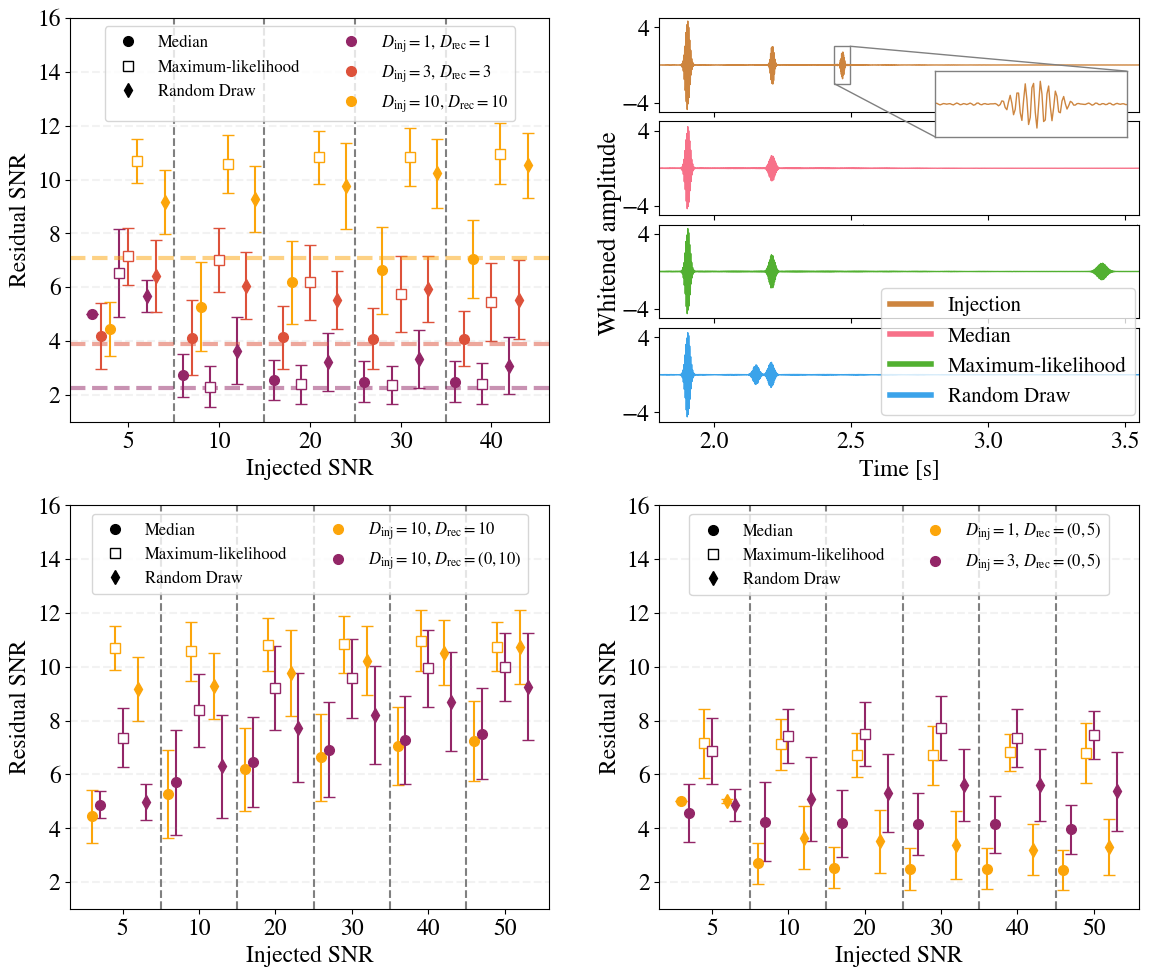

In [9]:
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(2, 2, figure=fig)

# top-left residuals
ax1 = fig.add_subplot(gs[0, 0])
plot_residuals_3D(ax1, results_D1,df_N3_fixD3,df_N10_fix10,'$D_\mathrm{inj}=1$, $D_\mathrm{rec}=1$','$D_\mathrm{inj}=3$, $D_\mathrm{rec}=3$','$D_\mathrm{inj}=10$, $D_\mathrm{rec}=10$')

# bottom-right waveform panel (4 rows)
inner_gs = gs[0, 1].subgridspec(4, 1, hspace=0.1)
axs = [fig.add_subplot(inner_gs[i, 0]) for i in range(4)]
plot_waveform_panels(axs, df)

# top-right residuals
ax2 = fig.add_subplot(gs[1, 0])
plot_residuals_2D(ax2, df_N10_fix10,df_N10_dmax10,'$D_\mathrm{inj}=10$, $D_\mathrm{rec}=10$','$D_\mathrm{inj}=10$, $D_\mathrm{rec}=(0,10)$')

# bottom-left residuals
ax3 = fig.add_subplot(gs[1, 1])
plot_residuals_2D(ax3, results_D5, df_N3_dmax5,'$D_\mathrm{inj}=1$, $D_\mathrm{rec}=(0,5)$','$D_\mathrm{inj}=3$, $D_\mathrm{rec}=(0,5)$')

plt.tight_layout()
plt.show()